In [20]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torch
from tqdm import tqdm

from dataset.TwoMoonDataset import TwoMoonDataset
from sklearn import datasets

from flow_models.PatchFlowModel import PatchFlowModel
from trainer import log_likelihood_loss

In [21]:
os.getcwd()

'/home/pb/Projects/nf-for-inv-problems'

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
def get_batch(samples):
    data, _ = datasets.make_moons(n_samples=samples, noise=0.06)
    return torch.from_numpy(np.array(data, dtype=np.float32))

In [24]:
batch = get_batch(512)
batch.shape

torch.Size([512, 2])

Plot of the prior distribution

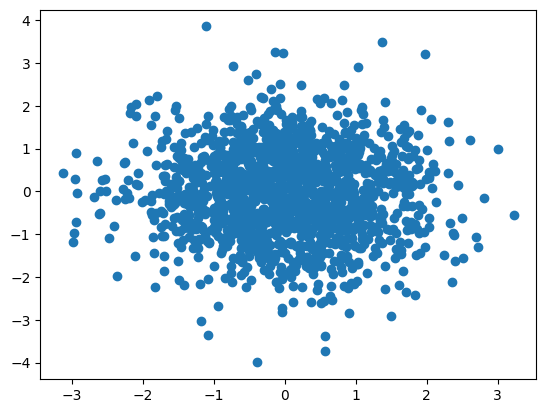

In [25]:
a, b  = zip(*np.random.multivariate_normal(np.zeros(2), np.eye(2), 1500))
plt.scatter(a,b)

Plot of the target distribution

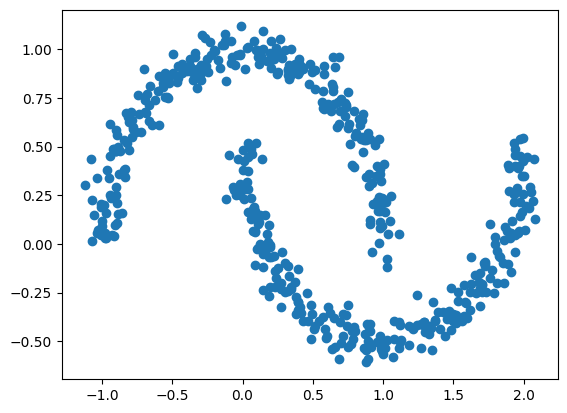

In [26]:
x, y= zip(*batch)
plt.scatter(x, y)

In [27]:
flow = PatchFlowModel(hparams={"num_layers": 17, "sub_net_size": 64, "dimension": 2}, device=DEVICE)
flow.to(DEVICE)

PatchFlowModel(
  (model): ReversibleGraphNet(
    (module_list): ModuleList(
      (0): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
        (subnet2): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): PermuteRandom()
      (2): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=

In [28]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

In [29]:
bar = tqdm(range(8000))
loss_g = []
for i in bar:
    loss = 0
    z, z_log_det = flow(get_batch(512).to(DEVICE), rev=True)
    loss += log_likelihood_loss(z, z_log_det)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_g.append((i, loss.item()))
    bar.set_description_str(f'loss: {loss.item()}')



loss: -0.6759195327758789:   2%|▏         | 121/8000 [00:04<05:11, 25.27it/s] 


KeyboardInterrupt: 

In [80]:
torch.save(flow.get_state(), '../results/moon_flow.pth')

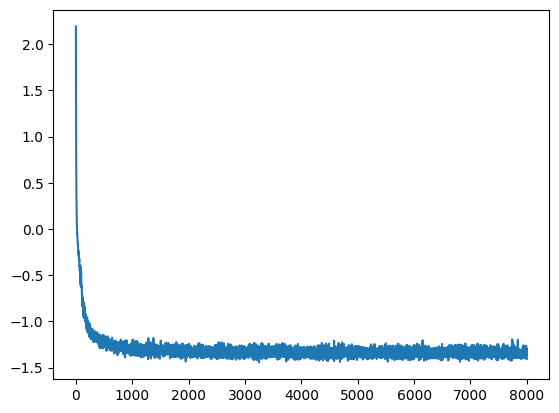

In [81]:
x, y = zip(*loss_g)
plt.plot(x, y)